# Edge filtering notebook

In [1]:
%matplotlib inline
from skimage.io import imread, imsave
import numpy as np
import os
from matplotlib import pyplot as plt

data_dir = 'D:\data\mixed'
src_filename = r'0000(I-1-1)060614-131746_e_0_16.bmp'
src = 255 * np.array(imread(os.path.join(data_dir, src_filename), 0))


In [2]:
def _reshape_segm_data(segm_list, src_h, dst_h):
    resize_ratio = float(dst_h) / src_h
    return list(map(lambda x: int(resize_ratio * x), segm_list))

def _get_segm_dict(markup_file_path):
    segm_data = dict()
    with open(markup_file_path, 'r') as f:
        lines = f.readlines()[1:]
        for row in lines:
            data = row.split('\t')
            name = data[0]
            xp,yp,rp = map(int, data[4:7])
            xi,yi,ri = map(int, data[8:11])
            segm_data[name] = [xp, yp, rp, xi, yi, ri]
    return segm_data



In [4]:
segm_data = _get_segm_dict(r'D:\data\mixed\params_res.txt')
print(segm_data[src_filename])
xp, yp, rp, xi, yi, ri = _reshape_segm_data(segm_data[src_filename], 480, 180)

[437, 214, 59, 436, 214, 124]


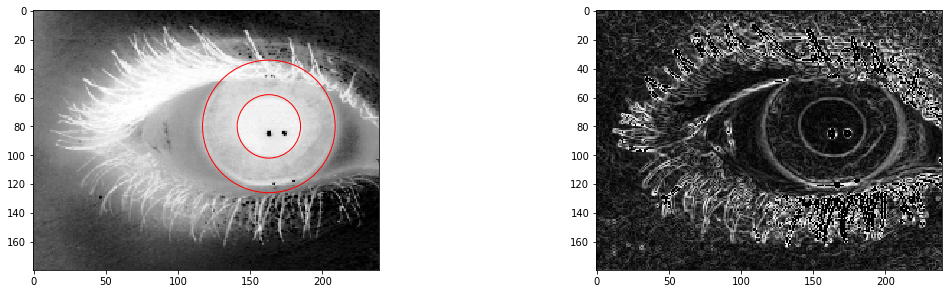

In [6]:
from scipy.ndimage import convolve, correlate
from skimage.transform import resize, finite_radon_transform
from skimage import exposure
from skimage.draw import circle
src = 1 - exposure.equalize_hist(src)
src_resized = np.array( 255 * resize(src, (180,240), mode='reflect')).astype(np.int)


sobel_x = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]])
sobel_y = sobel_x.T

src_x = np.array(correlate(src_resized, sobel_x, mode='reflect')).astype(np.int)
src_y = np.array(correlate(src_resized, sobel_y, mode='reflect')).astype(np.int)
src_val = np.sqrt(src_x*src_x + src_y*src_y)


src_val_thresh_high = np.percentile(src_val.ravel(), 95)
# src_val_thresh_low = np.percentile(src_val.ravel(), 50)

src_val = src_val * (src_val<src_val_thresh_high)
# src_val = src_val * (src_val > src_val_thresh_low)
src_val = np.array(src_val / src_val_thresh_high * 255).astype(np.uint8)

# featuremap_mask = circle()

plt.subplot(221)
_pupil = plt.Circle((xp,yp), radius=rp, fill=False, color='r')
_iris = plt.Circle((xi,yi), radius=ri, fill=False, color='r')
plt.imshow(src_resized, cmap='gray')
ax=plt.gca()
ax.add_artist(_pupil)
ax.add_artist(_iris)
plt.subplot(222)
plt.imshow(src_val, cmap='gray')
# plt.subplot(223)
# plt.imshow(src_resized, cmap='gray')
# plt.subplot(224)
# plt.imshow(src_val, cmap='gray')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)